<a href="https://colab.research.google.com/github/AYEOOON/AI-project/blob/main/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

이번 튜토리얼에서는 transfer learning(전이학습)을 사용하여 image classification용 CNN을 어떻게 학습하는지를 배운다.

transfer learning의 두 가지 주요 시나리오는 다음과 같다.

**Finetuning the convnet**
랜덤 초기화 대신, imagenet 데이터셋으로 학습된 모델같이 pretrained network를 사용하여 네트워크를 초기화한다.

**ConvNet as fixed feature extractor**
마지막 fully connected layer를 제외한 모든 레이어의 weight를 고정시키고, 마지막 fully connected layer를 랜덤 weight로 새롭게 구성하고 그것만 학습시킨다.


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## Load Data

torchvision.utils.data를 사용해서 data를 읽어온다.

개미와 벌을 분류하는 모델을 학습시킬 것이다. 각 개미와 벌 120장 학습 이미지와 75장 검증 이미지 를 사용하는데, 이는 일반화하는데 매우 작은 데이터셋이다. 그러나 transfer learning을 사용하기 때문에 괜찮은 성능을 갖는 모델을 학습시킬 수 있다.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms = {
	'train': transforms.Compose([
			transforms.RandomResizedCrop(224),
			transforms.RandomHorizontalFlip(),
			transforms.ToTensor(),
			transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
	'val' : transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	])
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
data augmentation을 이해하기 위해 학습용 이미지 데이터를 시각화한다.



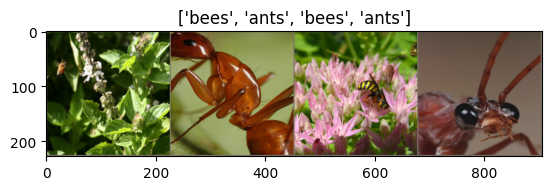

In [ ]:
def imshow(inp, title=None):
	inp = inp.numpy().transpose((1,2,0))
	mean = np.array([0.485, 0.456, 0.406])
	std = np.array([0.229, 0.224, 0.225])
	inp = std * inp + mean
	inp = np.clip(inp, 0, 1)
	plt.imshow(inp)
	if title is not None:
		plt.title(title)
	plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
	since = time.time()
	best_model_wts = copy.deepcopy(model.state_dict())
	best_acc = 0.0

	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch, num_epochs -1))
		print('-'*10)

		for phase in ['train', 'val']:
			if phase == 'train':
				model.train()
			else:
				model.eval()

			running_loss = 0.0
			running_corrects = 0

			for inputs, labels in dataloaders[phase]:
				inputs = inputs.to(device)
				labels = labels.to(device)

				optimizer.zero_grad()

				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inputs)
					_, preds = torch.max(outputs, 1)
					loss = criterion(outputs, labels)

					if phase == 'train':
						loss.backward()
						optimizer.step()

				running_loss += loss.item() * inputs.size(0)
				running_corrects += torch.sum(preds == labels.data)
			if phase == 'train':
				scheduler.step()

			epoch_loss = running_loss / dataset_sizes[phase]
			epoch_acc = running_corrects.double() / dataset_sizes[phase]

			print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

			if phase == 'val' and epoch_acc > best_acc:
				best_acc = epoch_acc
				best_model_wts = copy.deepcopy(model.state_dict())

		print()

	time_elapsed = time.time()
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
	print('Best val Acc : {:4f}'.format(best_acc))

	model.load_state_dict(best_model_wts)
	return model

### 예측 결과 시각화

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
	was_training = model.training
	model.eval()
	images_so_far = 0
	fig = plt.figure()

	with torch.no_grad():
		for i, (inputs, labels) in enumerate(dataloaders['val']):
			inputs = inputs.to(device)
			labels = labels.to(device)

			outputs = model(inputs)
			_, preds = torch.max(outputs, 1)

			for j in range(inputs.size()[0]):
				images_so_far += 1
				ax = plt.subplot(num_images//2, 2, images_so_far)
				ax.axis('off')
				ax.set_title('predicted: {}'.format(class_names[preds[j]]))
				imshow(inputs.cpu().data[j])

				if images_so_far == num_images:
					model.train(mode=was_training)
					return
		model.train(mode=was_training)

## ConvNet 미세조정

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5034 Acc: 0.7541
val Loss: 0.2358 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3564 Acc: 0.8320
val Loss: 0.5540 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.5437 Acc: 0.7951
val Loss: 0.6029 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.3117 Acc: 0.8689
val Loss: 0.3250 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4821 Acc: 0.8074
val Loss: 0.3257 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3688 Acc: 0.8607
val Loss: 0.4256 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.5180 Acc: 0.7787
val Loss: 0.2250 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3281 Acc: 0.8648
val Loss: 0.2335 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3461 Acc: 0.8443
val Loss: 0.2809 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3645 Acc: 0.8197
val Loss: 0.2266 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2609 Acc: 0.8934
val Loss: 0.2042 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2343 Acc: 0.9180
val Loss: 0.2039 Acc: 0.9150

Ep

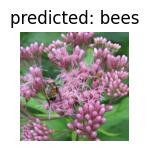

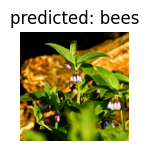

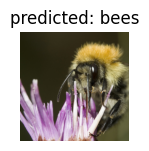

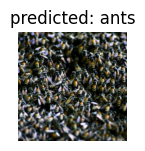

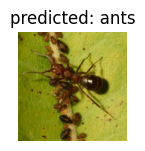

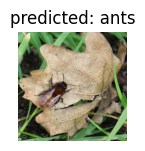

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3516 Acc: 0.8402
val Loss: 0.1915 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.3114 Acc: 0.8689
val Loss: 0.1952 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3807 Acc: 0.8033
val Loss: 0.2108 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3691 Acc: 0.8361
val Loss: 0.1767 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3665 Acc: 0.8361
val Loss: 0.1993 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3294 Acc: 0.8525
val Loss: 0.1879 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3069 Acc: 0.8648
val Loss: 0.1844 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3499 Acc: 0.8361
val Loss: 0.1923 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3714 Acc: 0.8443
val Loss: 0.2237 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3042 Acc: 0.8484
val Loss: 0.1908 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3157 Acc: 0.8607
val Loss: 0.1913 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3160 Acc: 0.8607
val Loss: 0.2097 Acc: 0.9412

Ep

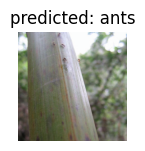

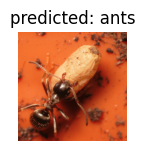

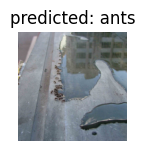

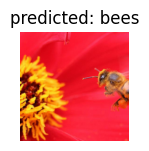

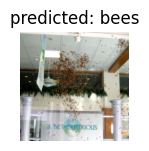

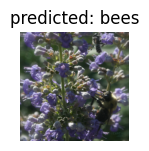

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
from PIL import Image
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

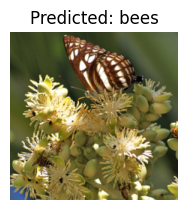

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



